# Explore Models

Refer to the script of Explore models written by Baihua

Model: MW_BASE_RC8_UpperROCONNEL.rsproj
Created by: Qian W
Date created: 3/11/18

Try to find structures about Source by veneer-py:
0 What are the constituents in the model?
1 What functional units in this URO catchment?
2 Does each funtional unit have its own model and parameters?
3 What are the input data for each submodel/function? How to change the values?

In [1]:
import veneer 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from SALib.test_functions import Sobol_G, Ishigami

from SALib.util import read_param_file
from SALib.plotting.morris import horizontal_bar_plot, covariance_plot, \
                                sample_histograms
import matplotlib.pyplot as plt

%matplotlib inline

## Open Source project file, then enable Veneer (Tools->Web Server Monitoring->Allow scripts) 
v = veneer.Veneer(port=9876)

In [2]:
#### Run this to improve model performance, mainly through parallel computing. These can also be modified through Source UI
def configure_options(self,options):
    lines = ["# Generated Script","from Dynamic_SedNet.PluginSetup import DSScenarioDetails"]
    lines += ["DSScenarioDetails.%s = %s"%(k,v) for (k,v) in options.items()]
    script = '\n'.join(lines)
    #print(script)
    res = self.model._safe_run(script)
    
configure_options(v,{'RunNetworksInParallel':True,'PreRunCatchments':True,'ParallelFlowPhase':True})
# v.model.sourceScenarioOptions("PerformanceConfiguration","ProcessCatchmentsInParallel",True)

In [3]:
#### Run this to turn off dsednet reporting window
configure_options(v,{'ShowResultsAfterRun':False,'OverwriteResults':True})

In [4]:
## Identify list of constituents
const = v.model.get_constituents()
const_df = pd.DataFrame(const)
const_df

,0
0,24-D
1,Ametryn
2,Atrazine
3,Diuron
4,Fluroxypyr
5,Glyphosate
6,Hexazinone
7,Imazapic
8,Isoxaflutole
9,Metribuzin


In [5]:
#Identify the list of function units
fun_units = set(v.model.catchment.get_functional_unit_types())
fun_units_df = pd.DataFrame(list(fun_units))
fun_units_df

,0
0,Conservation
1,Forestry
2,Other
3,Grazing Open
4,Horticulture
5,Urban
6,Grazing Forested
7,Dryland Cropping
8,Irrigated Cropping
9,Water


In [35]:
#Get names of catchments
cmt_names = v.model.catchment.names()
cmt_names

In [22]:
cmt_names = ['SC #49'] #, 'SC #47', 'SC #48', 'SC #49'
ct_area = []
for ct in cmt_names:
    ct_area.append(v.model.catchment.get_areas(catchments=ct)[0])
ct_area_total = np.sum(ct_area)

In [23]:
ct_area_total

119004300

In [24]:
fun_subc_df = pd.DataFrame()
for ct in cmt_names:
    print(ct)
    for i in range(len(fun_units_df)):
        fu = fun_units_df.iloc[i].values[0]
        area_fus = v.model.catchment.get_functional_unit_areas(fus=fu, catchments=ct)
        fun_subc_df.loc[i, ct] = area_fus[0]
# reset index for the dataframe
fun_subc_df.set_index(fun_units_df[0].values, inplace=True)
fun_subc_df.index.name = 'fun_units'
# fun_subc_df.to_csv('fu_areas.csv')

SC #49


In [25]:
fun_subc_df

,SC #49
fun_units,
Conservation,1.006311e+07
Forestry,3.985255e+07
Other,0.000000e+00
Grazing Open,2.998699e+07
Horticulture,3.866425e+05
Urban,0.000000e+00
Grazing Forested,3.747624e+07
Dryland Cropping,0.000000e+00
Irrigated Cropping,0.000000e+00


In [43]:
for fu in fun_units_df.index:
    fun_units_df.loc[fu,'proportion'] = fun_units_df.loc[fu, :].sum() / ct_area_total
fun_units_df.to_csv('C:/UserData/wangd/cloudStor/PhDocs/pce_fixing/func_units_area.csv')

In [ ]:
#find models
models = v.model.catchment.get_models(catchments = 'SC #53')
models

In [ ]:
#find parameters
v.model.find_parameters('RiverSystem.Catchments.Catchment')

In [ ]:
# List of generation models
gen_models = set(v.model.catchment.generation.get_models(constituents = 'Sediment - Fine', catchments = 'SC #53'))
gen_models

# Parameters and value ranges of each generation model
model_params = {}

for ele in gen_models:
    params = v.model.find_parameters(ele) #Get parameters of a certain model
    
    param_values = {}
    for param in params:
        param_value = v.model.catchment.generation.get_param_values(param)
        param_values[param] = [min(param_value), max(param_value), len(param_value)] #get min, max and lenth of a  parameter
    model_params[ele] = param_values
    
model_params

In [ ]:
#find models of specific catchment and constituents
gen_models = set(v.model.catchment.generation.get_models(constituents = 'Sediment - Fine'))
gen_models

In [ ]:
pd.set_option('max_colwidth',200) #set length of dataframe outputs
gen_model_names = model_params.keys()
pd.DataFrame(list(gen_model_names))

Use the information and in Source UI-> SedNet Utilities -> Constituent Generation Model Matrix Viewer

Generation models related to fine sediment：
RiverSystem.Catchments.Models.ContaminantGenerationModels.NilConstituent for Water
RiverSystem.Catchments.Models.ContaminantGenerationModels.EmcDwcCGModel for Conservation, Forestry, Horticulture, Urban, Other
Dynamic_SedNet.Models.SedNet_Sediment_Generation for Grazing Forested, Grazing Open
GBR_DynSed_Extension.Models.GBR_CropSed_Wrap_Model for Sugarcane, Dryland Cropping, Irrigated Cropping


In [ ]:
## To find the parameters: 
param_emcdwc = v.model.find_parameters('Dynamic_SedNet.Models.SedNet_Sediment_Generation')
print(param_emcdwc)

param_dwc = v.model.catchment.generation.get_param_values('Alpha')
print(param_dwc)



In [ ]:
# transport models
transport_models = v.model.link.constituents.get_models(constituents = 'Sediment - Fine')
set(transport_models)

In [ ]:
#find parameters for sediment transport model
transport_models = v.model.find_parameters('Dynamic_SedNet.Models.SedNet_InStream_Fine_Sediment_Model')
pd.DataFrame(transport_models)

Use the above information and Source UI -> SetNet Model Setup -> Edit Routing and Instream Models
Transport models for fine sediment:
'Dynamic_SedNet.Models.SedNet_InStream_Fine_Sediment_Model'

In [ ]:
#get node models
set(v.model.node.get_models())

In [ ]:
#get parameters for node model
v.model.find_parameters('RiverSystem.Nodes.Confluence.ConfluenceNodeModel')

## Find Parameters used for fine sediment

In [ ]:
gen_models

In [ ]:
#get all models for sediment generation and transport in this project
sed_gen_models = ['Dynamic_SedNet.Models.SedNet_Sediment_Generation','GBR_DynSed_Extension.Models.GBR_CropSed_Wrap_Model',
                'RiverSystem.Catchments.Models.ContaminantGenerationModels.EmcDwcCGModel']
sed_trp_models = ['Dynamic_SedNet.Models.SedNet_InStream_Fine_Sediment_Model']
sed_gen_params = []
for model in sed_gen_models:
    sed_gen_param = v.model.find_parameters(model)
    sed_gen_params = sed_gen_params + sed_gen_param
sed_trp_params = v.model.find_parameters(sed_trp_models)
#sed_gen_params
print('These are %d parameters for sediment generation models\n' % len(sed_gen_params))
print(pd.DataFrame(sed_gen_params))

print('\nThese are %d parameters for sediment transport models\n' % len(sed_trp_params))
print(pd.DataFrame(sed_trp_params))

In [ ]:
# Overview of parameters for fine sediment, such as the count of the parameter values, and unique values (e.g. are they constant/binary/vary, numeric/string)
for param in sed_gen_params:
    param_value = v.model.catchment.generation.get_param_values(param)
    param_value_len = len(param_value)
    param_value_set = set(param_value) #get uni
    print(param, param_value_len, param_value_set)

In [ ]:
# Overview of parameters for fine sediment, such as the count of the parameter values, and unique values (e.g. are they constant/binary/vary, numeric/string)
for param_trp in sed_trp_params:
    param_value = v.model.link.constituents.get_param_values(param_trp)
    param_value_len = len(param_value)
    param_value_set = set(param_value) #get uni
    print(param_trp, param_value_len, param_value_set)

## Change parameter values

In [ ]:
#place all parameters (for both sediment generation and transport) together
myparam_sed_gen = ['DeliveryRatioSeepage','DeliveryRatioSurface','Gully_Management_Practice_Factor','Gully_SDR_Fine','HillslopeCoarseSDR','HillslopeFineSDR','USLE_HSDR_Fine','Max_Conc']

# either using selected testing parameters (myparam_sedidin_gen) or all parameters (params_seddin_gen)
for i in myparam_sed_gen:
    param = v.model.catchment.generation.get_param_values(i)
    paraml = len(param) ## Count of the parameter values
    param_set = set(param) ## unique values 
    print(i, paraml, param_set)

In [ ]:
myparam_sed_trp = ['bankErosionCoeff','propBankHeightForFineDep','fineSedSettVelocity','fineSedReMobVelocity','RiparianVegPercent','UptakeVelocity']

# either using testing parameters (myparam_seddin_trp) or all parameters (params_seddin_trp)

for i in myparam_sed_trp:
    param = v.model.link.constituents.get_param_values(i)
    paraml = len(param) ## Count of the parameter values
    param_set = set(param) ## unique values 
    print(i, paraml, param_set)

In [ ]:
myparameters = myparam_sed_gen + myparam_sed_trp
myparameters

In [ ]:
sedigen_bounds = [[0, 2.5],
                  [0.5, 1],
                  [0, 2],
                  [0, 1.4],
                  [0, 1],
                  [0, 3],
                  [0, 2],
                  [0.1, 1]]
seditrp_bounds = [[0, 10],
                  [0.1, 2.5],
                  [0, 10],
                  [0, 3],
                  [0.1, 1.3],
                  [0.1, 10]]
mybounds = sedigen_bounds + seditrp_bounds
mybounds

In [ ]:
# Define the model inputs
problem = {
    'num_vars': len(myparameters),
    'names': myparameters,
    'bounds': mybounds,
    'groups': None
}
problem

In [ ]:
%%time
## Generate samples (Morris)
N = 10 
morris_level = 50
morris_grid = 2
optim_trj = False ## False or a int, >2 and <N, but generallly <=6
Loc_opt = False  ## True or False. 

samples_morris = sample(problem, N, num_levels=morris_level, grid_jump=morris_grid, optimal_trajectories = optim_trj, local_optimization=Loc_opt)
samples_morris
samples_morris.shape

In [ ]:
## Record initial parameter values. These values will be restored after each run.
initial_params = {}
for param_i, param_n in enumerate(problem['names']):
    param_gen = v.model.catchment.generation.get_param_values(param_n)
    param_trp = v.model.link.constituents.get_param_values(param_n)
    param_v = param_gen + param_trp
    initial_params[param_n] = param_v
print(initial_params)

In [ ]:
%%time
## Run model iteratively
v.drop_all_runs()

for index,item in enumerate(samples_morris):
    print(index)
    
    ## Update parameter values
    for param_i, param_n in enumerate(problem['names']):
        #print(param_i, param_n)
        #print(samples_morris[n,param_i])
        param_new = [x * samples_morris[index,param_i] for x in initial_params[param_n]]
        #print(initial_params[param_n], param_new)
        if param_n in myparam_sed_gen:
            assert v.model.catchment.generation.set_param_values(param_n,param_new, fromList=True)
        if param_n in myparam_sed_trp:
            assert v.model.link.constituents.set_param_values(param_n,param_new,fromList=True)

        
    ## Run model
    v.run_model(start='01/07/2000',end='30/06/2002')

## Return default parameter value
for param_i, param_n in enumerate(problem['names']):
    if param_n in myparam_sed_gen:
        v.model.catchment.generation.set_param_values(param_n,initial_params[param_n], fromList=True)
    if param_n in myparam_sed_trp:
        v.model.link.constituents.set_param_values(param_n,initial_params[param_n], fromList=True)

#        print(temp,samples_morris[n,param_i])

In [ ]:
help(v.retrieve_multiple_time_series)

In [ ]:
## Retrieve results
allruns = v.retrieve_runs()
result_sed=[]

for index, item in enumerate(allruns):
    run_name = allruns[index]['RunUrl']
    run_index = v.retrieve_run(run_name)
    finesediment = v.retrieve_multiple_time_series(run = run_name, run_data=run_index, criteria={'NetworkElement':'Outlet Node17','RecordingVariable':'Constituents@Sediment - Fine@Downstream Flow Mass'})
    result_sed.append(finesediment.mean()[0]) ## use [0] to extract value data only
    

## find constituents, models, parameters for sediment

In [ ]:
#obtain data sources
data_source = v.data_sources()
data_source.as_dataframe()

In [ ]:
set(v.model.catchment.get_functional_unit_types())

In [ ]:
constituents = v.model.get_constituents()
set(constituents)

In [ ]:
models = v.model.catchment.generation.get_models(constituents = 'Sediment - Fine' )
models_set = set(models)

In [ ]:
#get parameter values of sed
gen_params = []
for model in models_set:
    param_sed = v.model.find_parameters(model)
    gen_params += [{model: param_sed}]
gen_params

In [ ]:
for model in models_set:
    print(model,v.model.find_inputs(model))


In [ ]:
variables = v.variables()
variables.as_dataframe()

In [ ]:
v.model.find_model_type('Times')

In [ ]:
v.model.find_parameters('Dynamic_SedNet.Models.SedNet_TimeSeries_Load_Model')

In [ ]:
v.model.catchment.generation.get_param_values('Load_Conversion_Factor')

<IPython.core.display.Javascript object>


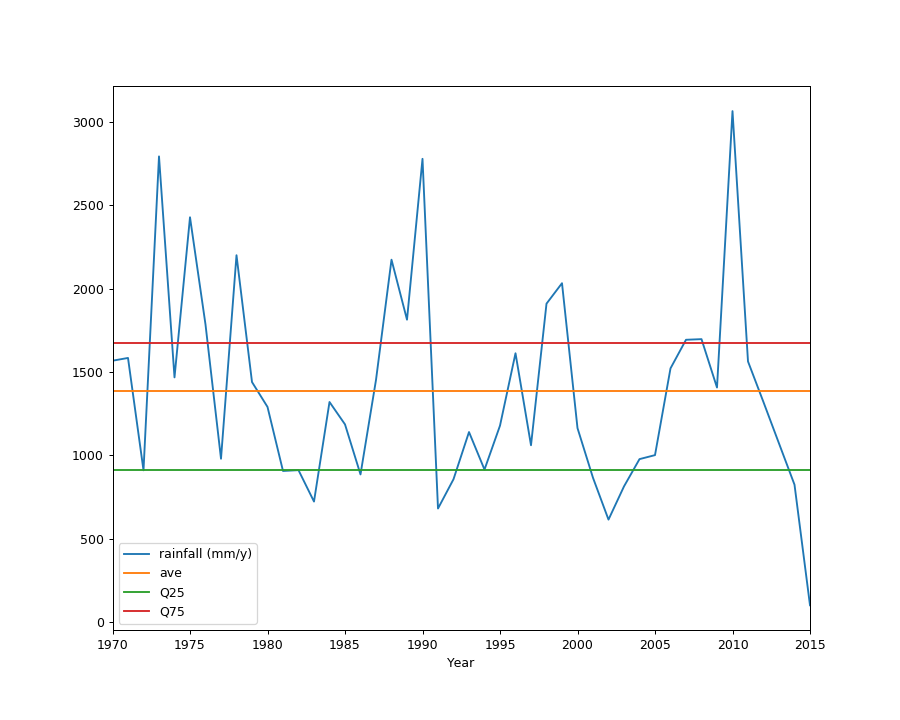

In [39]:
%matplotlib notebook
# Input variables
f_dir = 'rainfall_0101/'
f_name = 'rainfall_ave.csv'
rain = pd.read_csv('{}{}'.format(f_dir, f_name)).set_index('Unnamed: 0')
rain.index.name = 'Year'
rain.plot(figsize=(10, 8))